## Случайный лес

In [1]:
from sklearn.datasets import load_wine
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

plt.style.use('seaborn')

In [2]:
wine_data = load_wine()
df = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])
df['target'] = wine_data['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
df['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

Как мы видим кластеры равномерные, нет такого чтобы один преобладал сильно в количестве - это хорошо: классификатор не будет игнорировать какой-либо из кластеров.<br>
Инициализируем параметры модели:<br>
1. <b>n_estimators</b> - количество деревьев в лесу
2. <b>criterion</b> - критерий чистоты группы после разделении (Gini или Entropy)
3. <b>oob_score</b>- проверка каждого дерева как на тестовой выборке только на out-of-bag sample (остатки после выброса случайной выборки, на котором обучено дерево)
4. <b>class_weight</b> - веса для классов, если кластеры нерепрезентативны (например наблюдений кластера 1 в 100 раз больше других, поэтому классификатор будет всех относить к кластеру 1, что неверно)
5. <b>min_samples_split</b> - деревья можно переучить, поэтому их нужно ограничить в длине за счет установки минимального количество элементов в ноде. По дефолту деревья ветвятся до нод мощностью 1

In [4]:
from sklearn.ensemble import RandomForestClassifier

def init_forest(n_estimators):

    model = RandomForestClassifier(
        n_estimators=n_estimators, # количество деревьев
        random_state=42,
        criterion="gini", # критерий чистоты группы по Джини,
        oob_score=True, # проверка каждого дерева на out of bag sample - выборка полученная путем 
                        # отброса случайной выборки из датасета
        warm_start=False,
        class_weight=None # веса для классов, если кластеры несбалансированы
    )

    return model

model = init_forest(n_estimators=20)

In [5]:
df.shape

(178, 14)

На самом деле, у нас не такая уж и большая выборка, чтоб разбивать ее на обучающую, тестовую и валидационную выборку.

In [6]:
from sklearn.model_selection import train_test_split

x_values = df.iloc[:,:-1].values
y_values = df.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(
    x_values, y_values, test_size=0.2, random_state=42
)

model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=20, oob_score=True, random_state=42)

Проверим, что обучающая и тестовая выборка репрезентативна

In [7]:
print("Количества элементов кластеров в тестовой выборке: {}".format(np.unique(y_train, return_counts=True)[1]))
print("Количества элементов кластеров в тестовой выборке: {}".format(np.unique(y_test, return_counts=True)[1]))

Количества элементов кластеров в тестовой выборке: [45 57 40]
Количества элементов кластеров в тестовой выборке: [14 14  8]


In [8]:
y_pred = model.predict(x_test)
y_pred

array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0])

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'accuracy score: {accuracy}')

accuracy score: 1.0


Построим confusion matrix и посмотрим, где ошибается наша модель

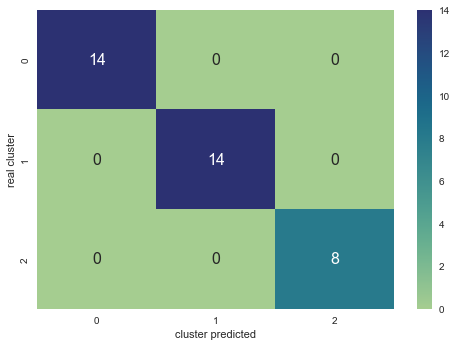

In [10]:
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

confused_df = pd.DataFrame(matrix, range(3), range(3))

def plot_confusion_matrix(confused_df):
    sn.heatmap(confused_df, annot=True, annot_kws={"size": 16}, cmap="crest")
    plt.xlabel('cluster predicted')
    plt.ylabel('real cluster')
    plt.show()

plot_confusion_matrix(confused_df)

Отлично, в первый же раз мы получили accuracy 1. Но возможно на других подвыборках модель будет вести себя намного хуже проверим это.

In [11]:
from sklearn.model_selection import cross_val_score

np.average(cross_val_score(model, x_values, y_values, cv=5)) # разделим данные на 
                                                             # 5 подвыборок и будем убирать по одной в тест

0.9609523809523809

Хороший результат. Построим график зависимости accuracy от количества деревьев. Так как качество деревьев сильно зависит от рандомного выбора наблюдений из выборки, сделаем n-шаговую кроссвалидацию и возьмем среднее accuracy для оценки точности модели

In [12]:
accuracy_list = []

for i in range(10,50):
    model = init_forest(i)
    accuracy_list.append(np.average(cross_val_score(model, x_values, y_values, cv=5)))

Text(0.5, 0, 'количество деревьев')

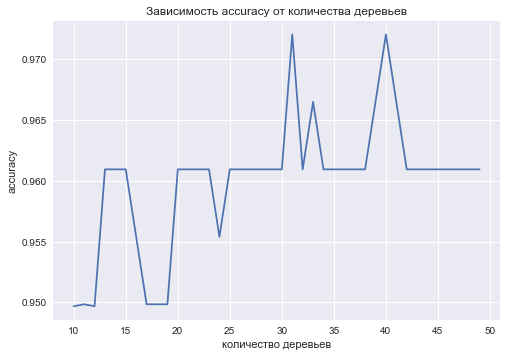

In [13]:
plt.plot(range(10,50), accuracy_list)
plt.title('Зависимость accuracy от количества деревьев')
plt.ylabel('accuracy')
plt.xlabel('количество деревьев')

Как мы видим, выборка у нас конечно сбалансирована, но сбалансируем ее до конца

In [14]:
df['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

 <h3>Undersampling</h3><br>
Выбросим часть наблюдений из 1 и 0 кластера, чтобв везде было по 48 элементов

In [15]:
second_cluster_data = df[df['target']==2]
zero_cluster_data = df[df['target']==0].sample(48) # Рандомно насэмплить 48 наблюдений из кластера 
                                                                  # где таргет переменная 0
first_cluster_data = df[df['target']==1].sample(48) # Аналогично для кластера с таргетом 1

print("Размерность данных с нулевым кластером: {}".format(zero_cluster_data.shape))
print("Размерность данных с первым кластером: {}".format(first_cluster_data.shape))

df_under = pd.concat([zero_cluster_data, first_cluster_data, second_cluster_data], axis=0)
df_under['target'].value_counts()

Размерность данных с нулевым кластером: (48, 14)
Размерность данных с первым кластером: (48, 14)


0    48
1    48
2    48
Name: target, dtype: int64

Теперь сделаем сплит по данным и укажем, что мы хотим равное количество кластеров в трэйн и тест выборках<br>
<b>stratify</b> позволит разделить выборку равномерно по кластерам в трэйне и в тесте

In [16]:
x_values = df_under.iloc[:,:-1].values
y_values = df_under.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(
    x_values, y_values, test_size=0.2, random_state=42, stratify=df_under['target']
)

In [17]:
# Как мы видим в обоих случаях выборки сбалансированные
print(np.unique(y_train, return_counts=True))
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([39, 38, 38]))


(array([0, 1, 2]), array([ 9, 10, 10]))

In [18]:
# Снова инициализируем модель так же с 20 деревьями
model = init_forest(n_estimators=20)

model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=20, oob_score=True, random_state=42)

In [19]:
y_pred = model.predict(x_test)
y_pred

array([1, 1, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 0,
       0, 1, 2, 2, 2, 2, 1])

Посмотрим на accuracy после изменения сэмплирования выборки

accuracy score: 1.0


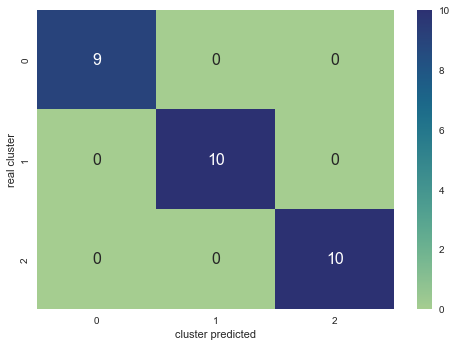

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'accuracy score: {accuracy}')

from sklearn.metrics import confusion_matrix

confused_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(confused_df)

Оно и видно, accuracy ухуджается за счет уменьшения наблюдений в train выборке. Проверим, что это точно так с помощью cross_val_score

In [21]:
np.average(cross_val_score(model, x_values, y_values, cv=5))

0.9862068965517242

В итоге получили, что <b>undersampling в среднем улучшает результаты классфикации</b>. Видимо, даже небольшая несбалансированность выборки повлияла на 0.02 в окончательном accuracy

<h3>Oversampling (клонирование данных)</h3><br>
Попробуем клонировать данные в кластерах до количества соответствующего максимально заселенному классу. То есть добавим в 0 и 2 кластер клонированных наблюдений, чтоб везде было по 71 

In [22]:
df['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

In [23]:
first_cluster_data = df[df['target']==1]
# Рандомно насэмплить 71 наблюдений из кластера где таргет переменная 0 (только, чтобы обеспечить максимальное количество уникальных
# значений я добавлю к существующему сету клонированные наблюдения)
zero_cluster_data = pd.concat([df[df['target']==0], df[df['target']==0].sample(12)])
# Аналогично для кластера с таргетом 1
second_cluster_data = pd.concat([df[df['target']==2], df[df['target']==2].sample(23)])

In [24]:
df_over = pd.concat([zero_cluster_data, first_cluster_data, second_cluster_data], axis=0)
df_over['target'].value_counts()

0    71
1    71
2    71
Name: target, dtype: int64

In [25]:
x_values = df_over.iloc[:,:-1].values
y_values = df_over.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(
    x_values, y_values, test_size=0.2, random_state=42, stratify=df_over['target']
)

In [26]:
# Снова инициализируем модель так же с 20 деревьями
model = init_forest(n_estimators=20)

model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=20, oob_score=True, random_state=42)

In [27]:
y_pred = model.predict(x_test)
y_pred

array([0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 0])

accuracy score: 0.9302325581395349


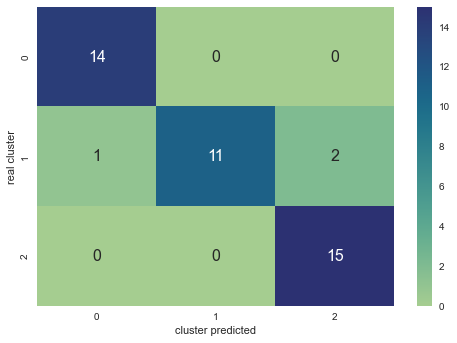

In [28]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'accuracy score: {accuracy}')

confused_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(confused_df)

При таких же остальных гиперпараметрах модель стала лучше относительно undersampling. Проверим снова с помощью cross_val_score

In [29]:
np.average(cross_val_score(model, x_values, y_values, cv=5))

0.9719822812846068

Результат получился такой же, видимо разницы особой нет, так как количество наблюдений невелико и кластеры относительно сбалансированы. Но мы точно улучшили изначальный результат, который был совсем без балансировки выборки

<h3>Oversampling using KNN - SMOTE</h3><br>
Расширение малых классов с помощью алгоритма KNN (улучшение простого клонирования)

In [30]:
from imblearn.over_sampling import SMOTE

x_values = df.iloc[:, :-1]
y_values = df.iloc[:, -1]

smote = SMOTE() # Добавлять синтетические наблюдения к меньшим классам
x_values, y_values = smote.fit_resample(x_values, y_values)

In [31]:
np.unique(y_values, return_counts=True)

(array([0, 1, 2]), array([71, 71, 71]))

In [32]:
# Снова инициализируем модель так же с 20 деревьями
model = init_forest(n_estimators=20)

model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=20, oob_score=True, random_state=42)

In [33]:
y_pred = model.predict(x_test)
y_pred

array([0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 0])

accuracy score: 0.9302325581395349


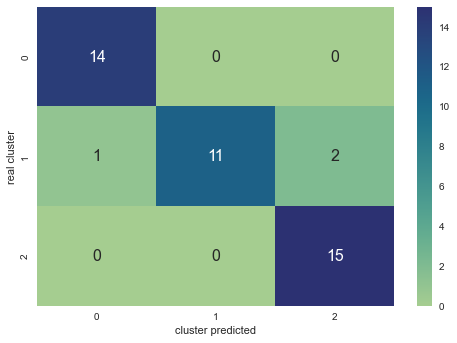

In [34]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'accuracy score: {accuracy}')

from sklearn.metrics import confusion_matrix

confused_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(confused_df)

In [35]:
np.average(cross_val_score(model, x_values, y_values, cv=5))

0.9813953488372092